In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib
import matplotlib.pyplot as plt
import argparse,os,time
import seaborn as sns

In [2]:
Deg2Rad = np.pi/180
Rad2Deg = 1/Deg2Rad

# dt = 0.1              # control frequency
# tf = 30               # final time
g = 9.8
K_alt = .8*2          # hdot loop gain    
RoC = 20              # maximum rate of climb (max. of hdot)
AoA0 = -1.71*Deg2Rad     # zero lift angle of attack
Acc2AoA = 0.308333*Deg2Rad  # 1m/s^2 ACC corresponds to 0.308333deg AOA 
zeta_ap = 0.7         # pitch acceleration loop damping
omega_ap = 4          # pitch acceleration loop bandwidth

dist_sep = 100        # near mid-air collision range


# hdot loop dynamics definition

def model(z, t, hdot_cmd):                          # computes state derivatives  
    Vm = 200  
    a, adot, h, hdot, R = z                           # state vector: a (pitch acc), adot, h (alt), hdot, R (ground-track range)
    gamma=np.arcsin(hdot/Vm)                          # fight path angle
    ac = K_alt * (hdot_cmd - hdot) + g/np.cos(gamma)  # pitch acceleration command
    ac = np.clip(ac, -30, 30)                         # maneuver limit
  
    addot = omega_ap*omega_ap*(ac-a) - 2*zeta_ap*omega_ap*adot
    hddot = a*np.cos(gamma) - g
    Rdot = Vm*np.cos(gamma)
    return np.array([adot, addot, hdot, hddot, Rdot]) # returns state derivatives 

In [3]:
num_scen = 1000
dt = 0.1              # control frequency
tf = 20               # final time
t = np.arange(0, tf, dt)
stop_point=random.randrange(4,len(t))
#     print(stop_point)
N = len(t)
r_all = []
for _ in range (num_scen):
    r_list = []
    hm0 = 1000                                                     # initial altitude
    Vm = 200                                                       # initial speed
    gamma0 = 0*Deg2Rad                                             # initial flight path angle
    Pm_NED = np.array([0, 0, -hm0])                                # initial NED position
    Vm_NED = np.array([Vm*np.cos(gamma0), 0, -Vm*np.sin(gamma0)])  # initial NED velocity

    # state variable: [a, adot, h, hdot, R]
    X0 = np.array([g/np.cos(gamma0), 0, hm0, -Vm_NED[2], 0])       # initial state vector

    # target initial conditions
    ht0 = 1000 + 50*(2*(np.random.rand())-1)
    Vt = 200
    approach_angle = 50*Deg2Rad*(2*np.random.rand()-1)
    psi0 = np.pi + approach_angle + 2*np.random.randn()*Deg2Rad
    psi0 = np.arctan2(np.sin(psi0), np.cos(psi0))

    Pt_N = 2000*(1+np.cos(approach_angle))
    Pt_E = 2000*np.sin(approach_angle)
    Pt_D = -ht0
    Pt_NED = np.array([Pt_N, Pt_E, Pt_D])                             # initial NED position
    Vt_NED = np.array([Vt*np.cos(psi0), Vt*np.sin(psi0), 0])       # initial NED velocity


    # initialize variables
    X = np.zeros((N,len(X0)))
    X[0,:] = X0
    dotX_p = 0

    Y = np.zeros((1,3))                       # print-out data
    theta0 = gamma0 + X0[0]*Acc2AoA + AoA0 # initial pitch angle

    DCM = np.zeros((3,3))                      # initial DCM NED-to-Body
    DCM[0,0] =  np.cos(theta0)
    DCM[0,2] = -np.sin(theta0)
    DCM[1,1] =  1
    DCM[2,0] =  np.sin(theta0)
    DCM[2,2] =  np.cos(theta0)

    Pr_NED = Pt_NED - Pm_NED                   # relative NED position
    Vr_NED = Vt_NED - Vm_NED                   # relative NED velosity

    Pr_Body = np.dot(DCM, Pr_NED)              # relative position (Body frame)

    # radar outputs
    r = np.linalg.norm(Pr_Body)                # range
    vc = -np.dot(Pr_NED, Vr_NED)/r             # closing velocity
    elev = np.arctan2(Pr_Body[2], Pr_Body[0])  # target vertival look angle (down +)
    azim = np.arctan2(Pr_Body[1], Pr_Body[0]/np.cos(theta0))  # target horizontal look angle (right +)

    los = theta0 - elev                        # line of sight angle
    dlos = 0
    daz = 0

    # static variables
    los_p = los
    dlos_p = dlos
    azim_p = azim
    daz_p = daz
    hdot_cmd = 0
    hdot = 0
    gamma = gamma0
    count_change_hdot=0
    err=0
    vc0=vc

    # main loop
    for k in range(N-1):  
        ##############################################################################
        # UPDATE ENVIRONMENT AND GET OBSERVATION

        # update environment
        # adams-bashforth 2nd order integration
        r_list.append(r)
        dotX = model(X[k,:], t[k], hdot_cmd)
        X[k+1,:] = X[k,:] + 0.5*(3*dotX-dotX_p)*dt
        dotX_p = dotX

        Pt_NED = Pt_NED + Vt_NED*dt        # target position integration

        # get observation

        a, adot, h, hdot, R = X[k+1,:]

        gamma = np.arcsin(hdot/Vm)
        theta = gamma + a*Acc2AoA + AoA0

        DCM = np.zeros((3,3))
        DCM[0,0] =  np.cos(theta)
        DCM[0,2] = -np.sin(theta)
        DCM[1,1] =  1
        DCM[2,0] =  np.sin(theta)
        DCM[2,2] =  np.cos(theta)

        Pm_NED = np.array([R, 0, -h]) 
        Vm_NED = np.array([Vm*np.cos(gamma), 0, -Vm*np.sin(gamma)])

        Pr_NED = Pt_NED - Pm_NED
        Vr_NED = Vt_NED - Vm_NED

        Pr_Body = np.dot(DCM, Pr_NED)

        r = np.linalg.norm(Pr_Body)
        vc = -np.dot(Pr_NED, Vr_NED)/r 
        elev = np.arctan2(Pr_Body[2], Pr_Body[0])
        azim = np.arctan2(Pr_Body[1], Pr_Body[0]/np.cos(theta))

        psi = np.arctan2(Vt_NED[1], Vt_NED[0])

        # los rate and az rate estimation
        los = theta - elev

        dlos = ( 30*(los-los_p) + 0*dlos_p ) / 3 # filtered LOS rate, F(s)=20s/(s+20)
        daz = ( 30*(azim-azim_p) + 0*daz_p ) / 3 # filtered azim rate, F(s)=20s/(s+20)

        los_p = los
        dlos_p = dlos
        azim_p = azim
        daz_p = daz

        # estimate closest approach
        min_dist_vert = r*r/vc*dlos
        min_dist_horiz = r*r/vc*daz

        # estimate cruise distance
        dist_cruise = r*los

        ##############################################################################
        # COMPUTE ACTION (BEGIN)
        if k>3 and r>dist_sep and abs(elev)<40*Deg2Rad and abs(azim)<40*Deg2Rad:
            if min_dist_vert>0:
                if min_dist_vert<dist_sep:
                    if np.abs(dist_cruise)<dist_sep:
                        if (min_dist_horiz <dist_sep):
                            if hdot_cmd != -20:
                                count_change_hdot+=1

                            hdot_cmd = -20
                        else:
                            hdot_cmd=0
                    else:
                        hdot_cmd=0
                else:
                    if np.abs(dist_cruise)>dist_sep:
                        hdot_cmd = 0
                    else:
                        if hdot_cmd != -20:
                            count_change_hdot+=1
                        hdot_cmd = -20
            else:
                if min_dist_vert>-dist_sep:
                    if np.abs(dist_cruise)<dist_sep:
                        if min_dist_horiz <dist_sep:
                            if hdot_cmd != 20:
                                count_change_hdot+=1

                            hdot_cmd = 20
                        else:
                            hdot_cmd=0
                    else:
                        hdot_cmd=0
                else:
                    if np.abs(dist_cruise)>dist_sep:
                        hdot_cmd = 0
                    else:
                        if hdot_cmd!=20:
                            count_change_hdot+=1
                        hdot_cmd=20
    r_all.append(r_list)

In [4]:
r_ary=np.array(r_all)

In [5]:
np.mean(np.min(r_all, axis=1))

126.04141030891512

(90.0, 200.0)

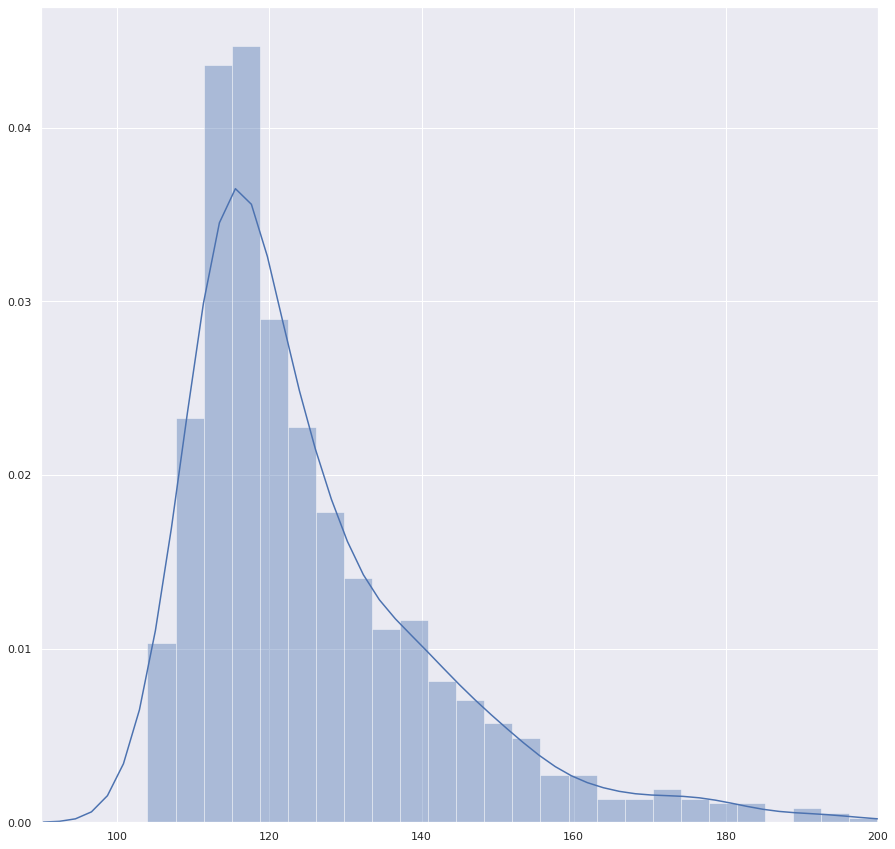

In [6]:
plt.figure(figsize=(15,15))
sns.set(color_codes=True)
sns.distplot(np.min(r_all, axis=1))
plt.xlim(90,200)